# Twitter Bot

## Credenciales

In [1]:
BEARER_TOKEN = "Pon el token de portador de tu aplicación de Twitter aquí"

## Importación de Tweepy y autenticación

In [2]:
import tweepy
import logging

# Crear registros para Tweepy

logger = logging.getLogger("tweepy")
logger.setLevel(logging.DEBUG)
handler = logging.FileHandler(filename="tweepy.log")
logger.addHandler(handler)

# Puede autenticarse como su aplicación con solo su token de portador
client = tweepy.Client(BEARER_TOKEN)

## Cargue un conjunto de datos y recupere tweets

In [3]:
import pandas as pd

df = pd.read_csv("data_repo.csv") # Conjunto de datos etiquetado (manualmente)

n_tweets = len(df['Tweet ID'])  
div = n_tweets//100      
ttexts = []
tids = []
miss = []

# Recuperar tweets existentes a partir del ID del tweett

for i in range(div):   
    tweet_ids = df['Tweet ID'][(i*100): (i + 1)*100]  
    response = client.get_tweets(list(tweet_ids), tweet_fields=['id', 'text', 'entities', 'lang'])
    response = response.data
    ttext = [tweet.text for tweet in response]
    tid = [tweet.id for tweet in response]
    ttexts.extend(ttext)
    tids.extend(tid)

for i in range(len(df['Tweet ID'])):
    if df['Tweet ID'][i] in tids:
        miss.append(df['is_misinfo'][i])


# Conjunto de datos final

dataset = pd.DataFrame(data = [tids, ttexts, miss]).transpose()
dataset.columns=['Tweet ID', 'Tweet', 'Misinforms']
display(dataset)

,Tweet ID,Tweet,Misinforms
0,1523014528379670528,oye ya pero si los #antivacuna no quieren vacu...,0
1,1523011912383881221,#Plandemia \n#LaVerdadEsUnaSola \n#AndaControl...,0
2,1523010676981387265,"@DENTRO_MADRID Si te gusta el bozal ponte 8, p...",1
3,1523009890868133894,@TAKER14719844 Nadie cree en dios\n por eso di...,0
4,1523007201844989954,@BegonaYarza basta de #DictaduraSanitaria nadi...,0
...,...,...,...
493,1522346116041392129,@eluniversocom NUNCA olvidaremos cómo @CapiZap...,0
494,1522345884498857985,"Tomemos conciencia, investiguemos, critiquemos...",1
495,1522343651673886721,"Hasta el Dr 🤡PayaZIN lo dice...\n""Algo está pa...",1
496,1522343275553861632,@lenantesur Qué rabia más grande! Y estupidez ...,0


## Tokenización de Tweets

In [4]:
from string import punctuation
import nltk
nltk.download("punkt")
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import re

def tweet_tokenization(sentence):

    # Eliminar puntuación y eliminar palabras vacías
    
    sentence = re.sub(r'http\S+', '', sentence)   # Eliminar URLs
    words = tokenizer.tokenize(sentence)   # Tokenización
    words = [char.lower() for char in words]  # Convertir a minúsculas
    new_words = [char for char in words if char not in punctuation]   # Eliminar puntuación
    new_words = [char for char in new_words if char not in stop]     # Eliminar palabras vacías
    sep_ = ' '.join(new_words)

    return new_words, sep_

stop = stopwords.words('spanish')
tokenizer = TweetTokenizer()
all_words = []
sep_words = []

for sentence in ttexts:
    new_words, sep_ = tweet_tokenization(sentence)
    sep_words.append(sep_)  
    all_words.extend(new_words)  # Almacenar las palabras resultantes

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Word Cloud

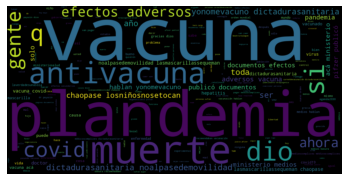

In [5]:
all_words = " ".join([word for word in all_words])  # Cree una sola cadena con todas las palabras (for word cloud)

from wordcloud import WordCloud
import matplotlib.pyplot as plt

wordcloud = WordCloud(width=1600, height=800).generate(all_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
wordcloud.to_file("test_wc.png")  # Guardar word cloud
plt.show()

## Entrenamiento

Accuracy: 70.0%


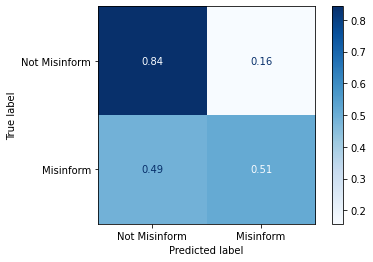

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn import metrics
import numpy as np

# División del conjunto de datos 

X_train,X_test,y_train,y_test = train_test_split(sep_words, list(dataset.Misinforms), test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()

# Vectorización de corpus de texto

tfidf_train = tfidf_vectorizer.fit_transform(X_train) 
tfidf_test = tfidf_vectorizer.transform(X_test)

# Modelo: Clasificador Pasivo-Agresivo

model = PassiveAggressiveClassifier(max_iter=1000)
model.fit(tfidf_train, y_train)

# Predicción y Precisión

prediction = model.predict(tfidf_test)
score = accuracy_score(y_test, prediction)
print(f'Accuracy: {round(score*100,2)}%')

# Matriz de confusión

from sklearn.metrics import ConfusionMatrixDisplay
cm = metrics.confusion_matrix(y_test, prediction)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(cm, display_labels=['Not Misinform', 'Misinform'])
disp.plot(cmap='Blues')
plt.savefig("./confusion_matrix.png")
plt.show()



## Probando con nuevos datos


In [7]:
query = '(#DictaduraSanitaria OR cubrecobas OR vacuna OR antivacuna) lang:es -is:retweet'  # Search term

# Obtención de max. 10 tweets
tweets = client.search_recent_tweets(query=query, 
                                    tweet_fields=['text', 'entities', 'lang', 'public_metrics', 'context_annotations'],
                                    max_results=10)

tweets = tweets.data

# Recuperar información de los tweets

ttext = [tweet.text for tweet in tweets]  
thash = []
for tweet in tweets:
    if tweet.entities is not None:
        if 'hashtags' in tweet.entities:
            th = []
            for hashtag in tweet.entities['hashtags']:
                th.append(hashtag['tag'])
            thash.append(th)

# Tokenización

sep_words = []
for text in ttext:
    _, sep_ = tweet_tokenization(text)
    sep_words.append(sep_)  

sep_words = tfidf_vectorizer.transform(sep_words)
pred = model.predict(sep_words)

# Dataframe para visualización

df = pd.DataFrame(data = [ttext, thash, pred]).transpose()
df.columns=['Tweets', 'Hashtags', 'Misinforms']
display(df)

# Exportar a csv
df.to_csv(r'./tweets_predict.csv', index = False)


,Tweets,Hashtags,Misinforms
0,🧵Lo mismo para vacuna #COVID19 en @vinadelmar ...,[COVID19],0
1,Qué jocoso este @jordievole!! No se ha enterad...,[sendhelp],1
2,@MaruMarisa6 @fmlidermdq @marimarher Yo prefie...,None,1
3,@helenablonde @DjokerNole @alcarazcarlos03 @Mu...,None,0
4,@ChakNorris93 @FrayJosepho Diría que la vacuna...,None,1
5,@ministeriosalud @CCuadradoN Metanse su mierda...,None,1
6,@no_vacruniado intranasal seria mas logico par...,None,1
7,"@carsua6 Cuando se los digo, me contestan: ¿qu...",None,0
8,@BeKind02464790 @nickkolargo @JoiJemi @Beatriz...,None,0
9,antier me dieron un putazo en la axila y ya me...,None,1


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d5f6b7e0-1273-4f0f-8b10-a5255946a684' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>